## Project Overview
This project implements malware detection using both classical machine learning models (Logistic Regression, SVM, Random Forest, XGBoost) and advanced models (TabTransformer, TabNet, FT-Transformer, and Graph Neural Networks).

## Group Details  

-Sanduni Kanapeddala Gamage- Student ID: 1598065

-Kahandawita Arachchige Arosh Malindra Perera- Student ID: 1579940

-Nanayakkarawasam Juliyan Stephan Nalaka De Silva- Student ID: 1585221

-Hungampala Ralalage Malaka Prasad- Student ID: 1599986

In [13]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

# Kaggle Dataset Loading - Only basic kaggle API (no kagglehub)
import sys
import subprocess
try:
    from kaggle.api.kaggle_api_extended import KaggleApi
    KAGGLE_AVAILABLE = True
except ImportError:
    try:
        print("Installing kaggle dependencies...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "kaggle"])
        from kaggle.api.kaggle_api_extended import KaggleApi
        KAGGLE_AVAILABLE = True
    except Exception as e:
        print(f"Could not install kaggle API: {e}")
        KAGGLE_AVAILABLE = False

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Classical ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Feature Importance and Explainability
import shap
from lime import lime_tabular

# Advanced ML Models - TabTransformer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pytorch_tabnet.tab_model import TabNetClassifier

# FT-Transformer (using PyTorch implementation)
class FTTransformer(nn.Module):
    def __init__(self, input_dim, output_dim, dim=32, depth=2, heads=4, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self.mlp_head = nn.Sequential(
            nn.Linear(dim, dim*2),
            nn.ReLU(),
            nn.Linear(dim*2, output_dim)
        )
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.transformer(x)
        x = x.squeeze(1)
        return self.mlp_head(x)

# Graph Neural Networks dependencies
# Checking if GNN functionality is available
""""
GNN_AVAILABLE = False
try:
    import torch_geometric
    from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
    from torch_geometric.data import Data
    from torch.utils.data import DataLoader as GraphDataLoader
    GNN_AVAILABLE = True
    print("GNN functionality is available!")
except ImportError:
    print("torch_geometric is not installed. GNN functionality will not be available.")
"""
# For visualization
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
# Kaggle data loading function
def load_kaggle_datasets(dataset_id="agungpambudi/network-malware-detection-connection-analysis"):
    """
    Load datasets directly from Kaggle using the Kaggle API.
    Uses pipe (|) separator and keeps datasets separate.
    
    Args:
        dataset_id: The Kaggle dataset ID to download
        
    Returns:
        Dictionary of DataFrames with dataset names as keys
    """
    # Check if kaggle is installed
    try:
        import kaggle
        from kaggle.api.kaggle_api_extended import KaggleApi
    except ImportError:
        print("Kaggle API is not installed. Installing...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "kaggle"])
            import kaggle
            from kaggle.api.kaggle_api_extended import KaggleApi
            print("Kaggle API installed successfully")
        except Exception as e:
            print(f"Failed to install Kaggle API: {e}")
            print("Please manually install with: pip install kaggle")
            return None
    
    # Check if kaggle.json exists
    import os
    kaggle_dir = os.path.join(os.path.expanduser('~'), '.kaggle')
    kaggle_json = os.path.join(kaggle_dir, 'kaggle.json')
    
    if not os.path.exists(kaggle_json):
        print(f"Kaggle API credentials not found at: {kaggle_json}")
        print("\nTo fix Kaggle authentication issues:")
        print("1. Create a Kaggle account at https://www.kaggle.com")
        print("2. Go to Account -> API -> Create New API Token")
        print("3. This will download kaggle.json")
        print("4. Place this file in ~/.kaggle/ (Linux/Mac) or C:\\Users\\<username>\\.kaggle\\ (Windows)")
        print(f"   For your system, that's: {kaggle_dir}")
        print("5. Run this cell again")
        
        # Create the .kaggle directory if it doesn't exist
        if not os.path.exists(kaggle_dir):
            try:
                os.makedirs(kaggle_dir)
                print(f"Created directory: {kaggle_dir}")
            except Exception as e:
                print(f"Could not create directory: {e}")
        
        return None
    
    # Initialize dictionary to store DataFrames
    datasets = {}
    
    # Create a directory in DataSet to store Kaggle files
    base_dir = os.path.dirname(os.path.abspath('__file__'))
    dataset_dir = os.path.join(base_dir, 'DataSet', 'kaggle_data')
    os.makedirs(dataset_dir, exist_ok=True)
    
    print(f"Downloading dataset {dataset_id} to {dataset_dir}...")
    
    try:
        # Initialize and authenticate Kaggle API
        api = KaggleApi()
        api.authenticate()
        
        # Download the dataset files
        api.dataset_download_files(dataset_id, path=dataset_dir, unzip=True)
        print("Download complete!")
        
        # List all CSV files in the directory
        csv_files = [f for f in os.listdir(dataset_dir) if f.endswith('.csv')]
        print(f"Found {len(csv_files)} CSV files in the Kaggle dataset")
        
        # Load each CSV file separately with pipe separator
        for file in tqdm(csv_files, desc="Loading CSV files"):
            file_path = os.path.join(dataset_dir, file)
            try:
                # Use pipe separator specifically
                df = pd.read_csv(file_path, sep='|', low_memory=False)
                
                # Store the DataFrame in the dictionary with filename as key
                key = file.replace('.csv', '')
                datasets[key] = df
                print(f"Successfully loaded {file} with {df.shape[0]} rows and {df.shape[1]} columns")
            except Exception as e:
                print(f"Error loading {file}: {e}")
        
        # Cache the datasets for future use
        cache_dir = os.path.join(base_dir, 'DataSet', 'cache')
        os.makedirs(cache_dir, exist_ok=True)
        cache_file = os.path.join(cache_dir, 'kaggle_datasets.pkl')
        
        print(f"Saving datasets to cache: {cache_file}")
        with open(cache_file, 'wb') as f:
            pickle.dump(datasets, f)
        print("Datasets cached successfully")
        
    except Exception as e:
        print(f"Error accessing Kaggle API: {e}")
        print("\nTo fix Kaggle authentication issues:")
        print("1. Create a Kaggle account at https://www.kaggle.com")
        print("2. Go to Account -> API -> Create New API Token")
        print("3. This will download kaggle.json")
        print("4. Place this file in ~/.kaggle/ (Linux/Mac) or C:\\Users\\<username>\\.kaggle\\ (Windows)")
        print("5. Run this cell again")
        return None
        
    if not datasets:
        print("No datasets were loaded from Kaggle")
        return None
        
    return datasets

# Load datasets from Kaggle or cache
try:
    # Check for cached datasets first
    cache_file = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'DataSet', 'cache', 'kaggle_datasets.pkl')
    
    if os.path.exists(cache_file):
        print(f"Loading datasets from cache: {cache_file}")
        with open(cache_file, 'rb') as f:
            datasets = pickle.load(f)
        print(f"Loaded {len(datasets)} datasets from cache")
    else:
        print("No cached datasets found. Loading from Kaggle...")
        datasets = load_kaggle_datasets()
        
    # Display available datasets
    if datasets:
        print("\nAvailable datasets:")
        for key, df in datasets.items():
            print(f"- {key}: {df.shape[0]} rows, {df.shape[1]} columns")
except Exception as e:
    print(f"Error loading datasets: {e}")
    import traceback
    traceback.print_exc()

Loading datasets from cache: d:\Unitec\Sem2\Machine learning\ML Project\DataSet\cache\kaggle_datasets.pkl
Loaded 12 datasets from cache

Available datasets:
- CTU-IoT-Malware-Capture-1-1conn.log.labeled: 1008748 rows, 23 columns
- CTU-IoT-Malware-Capture-20-1conn.log.labeled: 3209 rows, 23 columns
- CTU-IoT-Malware-Capture-21-1conn.log.labeled: 3286 rows, 23 columns
- CTU-IoT-Malware-Capture-3-1conn.log.labeled: 156103 rows, 23 columns
- CTU-IoT-Malware-Capture-34-1conn.log.labeled: 23145 rows, 23 columns
- CTU-IoT-Malware-Capture-35-1conn.log.labeled: 10447787 rows, 23 columns
- CTU-IoT-Malware-Capture-42-1conn.log.labeled: 4426 rows, 23 columns
- CTU-IoT-Malware-Capture-44-1conn.log.labeled: 237 rows, 23 columns
- CTU-IoT-Malware-Capture-48-1conn.log.labeled: 3394338 rows, 23 columns
- CTU-IoT-Malware-Capture-60-1conn.log.labeled: 3581028 rows, 23 columns
- CTU-IoT-Malware-Capture-8-1conn.log.labeled: 10403 rows, 23 columns
- CTU-IoT-Malware-Capture-9-1conn.log.labeled: 6378293 rows,

In [ ]:
# Detailed analysis of a specific dataset
def analyze_dataset(dataset_name):
    """
    Perform detailed analysis on a specific dataset
    
    Args:
        dataset_name: Key name of the dataset to analyze
    """
    if dataset_name not in datasets:
        print(f"Dataset '{dataset_name}' not found.")
        print(f"Available datasets: {list(datasets.keys())}")
        return
    
    df = datasets[dataset_name]
    
    # Basic information
    print(f"='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='=")
    print(f"DATASET: {dataset_name}")
    print(f"='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='=")
    print(f"Shape: {df.shape[0]} rows x {df.shape[1]} columns")
    
    # Column information
    print("\n--- COLUMNS ---")
    for col in df.columns:
        print(f"- {col}: {df[col].dtype}")
    
    # Sample data
    print("\n--- SAMPLE DATA ---")
    display(df.head())
    
    # Statistical summary
    print("\n--- STATISTICAL SUMMARY ---")
    display(df.describe())
    
    # Missing values
    print("\n--- MISSING VALUES ---")
    missing = df.isna().sum()
    if missing.sum() > 0:
        display(pd.DataFrame({
            'Column': missing.index,
            'Missing Values': missing.values,
            'Percentage': (missing.values / len(df) * 100).round(2)
        })[missing.values > 0].sort_values('Missing Values', ascending=False))
    else:
        print("No missing values found!")
    
    # Value counts for categorical columns (showing top categories)
    print("\n--- CATEGORICAL COLUMNS ---")
    cat_columns = df.select_dtypes(include=['object', 'category']).columns
    for col in cat_columns[:5]:  # Limiting to first 5 categorical columns
        print(f"\n{col}:")
        display(df[col].value_counts().head(10))
    
    if len(cat_columns) > 5:
        print(f"... and {len(cat_columns) - 5} more categorical columns (not shown)")
    
    # Numeric column distributions
    print("\n--- NUMERIC COLUMNS SUMMARY ---")
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    if len(num_cols) > 0:
        display(df[num_cols].describe())
    else:
        print("No numeric columns found!")
    
    return df

# List available datasets
print("Available datasets:")
for i, key in enumerate(datasets.keys()):
    print(f"{i+1}. {key}")

# Example: Analyze the first dataset (you can change the index as needed)
if datasets:
    dataset_name = list(datasets.keys())[0]  # First dataset
    print(f"\nAnalyzing first dataset: {dataset_name}")
    analyze_dataset(dataset_name)
else:
    print("No datasets available to analyze.")
    
    

Available datasets:
1. CTU-IoT-Malware-Capture-1-1conn.log.labeled
2. CTU-IoT-Malware-Capture-20-1conn.log.labeled
3. CTU-IoT-Malware-Capture-21-1conn.log.labeled
4. CTU-IoT-Malware-Capture-3-1conn.log.labeled
5. CTU-IoT-Malware-Capture-34-1conn.log.labeled
6. CTU-IoT-Malware-Capture-35-1conn.log.labeled
7. CTU-IoT-Malware-Capture-42-1conn.log.labeled
8. CTU-IoT-Malware-Capture-44-1conn.log.labeled
9. CTU-IoT-Malware-Capture-48-1conn.log.labeled
10. CTU-IoT-Malware-Capture-60-1conn.log.labeled
11. CTU-IoT-Malware-Capture-8-1conn.log.labeled
12. CTU-IoT-Malware-Capture-9-1conn.log.labeled

Analyzing first dataset: CTU-IoT-Malware-Capture-1-1conn.log.labeled
='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='=
DATASET: CTU-IoT-Malware-Capture-1-1conn.log.labeled
='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='='=
Shape: 1008748 rows x 23 columns

--- COLUMNS ---
- ts: float64
- uid: object
- id.orig_h: object
- id.orig_p: float64

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label,detailed-label
0,1.525880e+09,CUmrqr4svHuSXJy5z7,192.168.100.103,51524.0,65.127.233.163,23.0,tcp,-,2.999051,0,...,-,0.0,S,3.0,180.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan
1,1.525880e+09,CH98aB3s1kJeq6SFOc,192.168.100.103,56305.0,63.150.16.171,23.0,tcp,-,-,-,...,-,0.0,S,1.0,60.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan
2,1.525880e+09,C3GBTkINvXNjVGtN5,192.168.100.103,41101.0,111.40.23.49,23.0,tcp,-,-,-,...,-,0.0,S,1.0,60.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan
3,1.525880e+09,CDe43c1PtgynajGI6,192.168.100.103,60905.0,131.174.215.147,23.0,tcp,-,2.998796,0,...,-,0.0,S,3.0,180.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan
4,1.525880e+09,CJaDcG3MZzvf1YVYI4,192.168.100.103,44301.0,91.42.47.63,23.0,tcp,-,-,-,...,-,0.0,S,1.0,60.0,0.0,0.0,-,Malicious,PartOfAHorizontalPortScan



--- STATISTICAL SUMMARY ---


,ts,id.orig_p,id.resp_p,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,1.008748e+06,1.008748e+06,1.008748e+06,1008748.0,1.008748e+06,1.008748e+06,1.008748e+06,1.008748e+06
mean,1.526075e+09,4.443684e+04,1.609771e+04,0.0,1.496242e+00,8.114562e+01,1.424647e-01,9.049184e+00
std,1.157431e+05,9.660592e+03,1.956280e+04,0.0,1.741176e+00,9.473090e+01,1.850414e+00,1.196776e+02
min,1.525880e+09,3.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.525975e+09,4.373000e+04,2.300000e+01,0.0,1.000000e+00,4.000000e+01,0.000000e+00,0.000000e+00
50%,1.526071e+09,4.376300e+04,8.080000e+03,0.0,1.000000e+00,6.000000e+01,0.000000e+00,0.000000e+00
75%,1.526174e+09,4.881400e+04,2.818025e+04,0.0,1.000000e+00,6.000000e+01,0.000000e+00,0.000000e+00
max,1.526283e+09,6.539400e+04,6.553500e+04,0.0,6.000000e+01,2.990000e+03,7.500000e+01,9.415000e+03



--- MISSING VALUES ---
No missing values found!

--- CATEGORICAL COLUMNS ---

uid:
No missing values found!

--- CATEGORICAL COLUMNS ---

uid:


uid
CUmrqr4svHuSXJy5z7    1
COj4Eq4lmR86amgfI6    1
CBqL9l4KOG0Y3zauml    1
CLIXVIOgCuf9Pv6j      1
CImdWC3kB3Zhudx4q3    1
CkA64v2h8KpX8Q74Z3    1
CogrdgtK89aNUYYJd     1
CaKHRA4f0t6bWYCo93    1
CWtdXj3YoOcd5MAjm1    1
C2lNJW3oXHusTkzmdg    1
Name: count, dtype: int64


id.orig_h:


id.orig_h
192.168.100.103    991061
192.168.100.1        1651
4.68.110.10            43
194.70.98.42           23
218.248.235.161        13
83.168.243.156         12
144.75.175.50          11
38.104.45.226          11
218.248.235.129        10
159.226.254.70         10
Name: count, dtype: int64


id.resp_h:


id.resp_h
192.168.100.103    17687
147.231.100.5       4313
213.239.154.12      1428
37.187.104.44       1408
89.221.214.130      1402
210.206.154.134      129
70.45.29.240         128
175.196.5.46         125
92.255.209.3         125
221.5.224.77         124
Name: count, dtype: int64


proto:


proto
tcp     583134
udp     408193
icmp     17421
Name: count, dtype: int64


service:


service
-       1005507
http       3238
dhcp          1
ssh           1
dns           1
Name: count, dtype: int64

... and 10 more categorical columns (not shown)

--- NUMERIC COLUMNS SUMMARY ---


,ts,id.orig_p,id.resp_p,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,1.008748e+06,1.008748e+06,1.008748e+06,1008748.0,1.008748e+06,1.008748e+06,1.008748e+06,1.008748e+06
mean,1.526075e+09,4.443684e+04,1.609771e+04,0.0,1.496242e+00,8.114562e+01,1.424647e-01,9.049184e+00
std,1.157431e+05,9.660592e+03,1.956280e+04,0.0,1.741176e+00,9.473090e+01,1.850414e+00,1.196776e+02
min,1.525880e+09,3.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.525975e+09,4.373000e+04,2.300000e+01,0.0,1.000000e+00,4.000000e+01,0.000000e+00,0.000000e+00
50%,1.526071e+09,4.376300e+04,8.080000e+03,0.0,1.000000e+00,6.000000e+01,0.000000e+00,0.000000e+00
75%,1.526174e+09,4.881400e+04,2.818025e+04,0.0,1.000000e+00,6.000000e+01,0.000000e+00,0.000000e+00
max,1.526283e+09,6.539400e+04,6.553500e+04,0.0,6.000000e+01,2.990000e+03,7.500000e+01,9.415000e+03


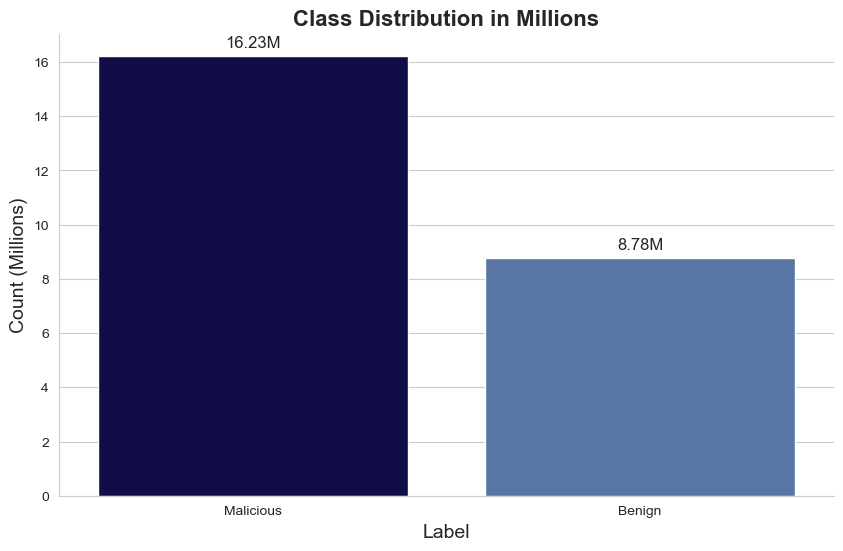

Malicious samples: 16,230,845 (64.89%)
Benign samples: 8,780,158 (35.11%)


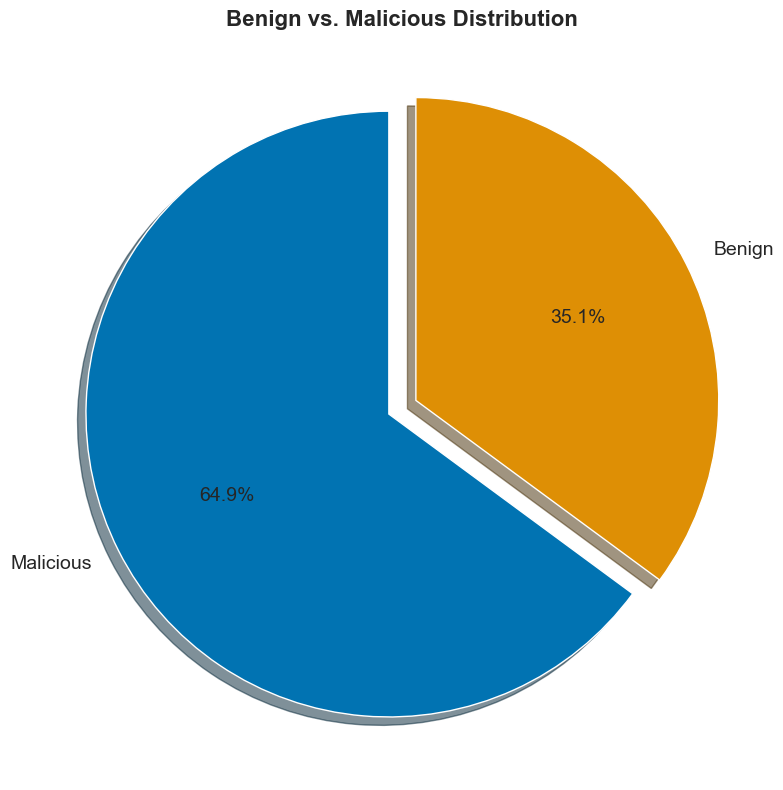

In [ ]:
# Create visualization of Benign vs Malicious distribution using Seaborn
# Collect all label values from all datasets
all_labels = []
for name, df in datasets.items():
    if 'label' in df.columns:
        # Standardize the labels to Benign and Malicious
        df_labels = df['label'].copy()
        df_labels = df_labels.apply(lambda x: "Benign" if "benign" in str(x).lower() else "Malicious")
        all_labels.append(df_labels)

if all_labels:
    # Concatenate all label series
    combined_labels = pd.concat(all_labels)
    
    # Convert to DataFrame for Seaborn
    df_plot = pd.DataFrame({'Label': combined_labels})
    
    # Count values and convert to millions
    counts = combined_labels.value_counts().reindex(["Malicious", "Benign"])
    counts_in_millions = counts / 1e6
    
    # Set the aesthetics for the plots
    sns.set_style("whitegrid")
    
    # Create the figure
    plt.figure(figsize=(10, 6))
    
    # Create a Seaborn bar plot
    ax = sns.barplot(x=counts.index, y=counts_in_millions, palette=["#090550", "#4C72B0"])
    
    # Add value labels on top of each bar
    for i, count in enumerate(counts_in_millions):
        ax.text(i, count + 0.3, f'{count:.2f}M', ha='center', fontsize=12)
    
    # Set title and labels with better fonts
    ax.set_title('Class Distribution in Millions', fontsize=16, fontweight='bold')
    ax.set_xlabel('Label', fontsize=14)
    ax.set_ylabel('Count (Millions)', fontsize=14)
    # Remove top and right spines
    sns.despine()
    plt.show()
    
    # Print counts for reference
    print(f"Malicious samples: {counts['Malicious']:,} ({counts['Malicious']/len(combined_labels)*100:.2f}%)")
    print(f"Benign samples: {counts['Benign']:,} ({counts['Benign']/len(combined_labels)*100:.2f}%)")
    
    # Create a pie chart using Seaborn color palette
    plt.figure(figsize=(8, 8))
    colors = sns.color_palette("colorblind")[0:2]
    plt.pie(counts, labels=counts.index, 
            autopct='%1.1f%%', startangle=90, colors=colors,
            explode=(0.05, 0.05), shadow=True, textprops={'fontsize': 14})
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title('Benign vs. Malicious Distribution', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("No 'label' column found in the datasets")

In [10]:
# Data Preprocessing
# Selecting relevant data sets by ignoring specific ones

# Define datasets to ignore - corrected names to match actual dataset keys
ignored_datasets = [
    "CTU-IoT-Malware-Capture-9-1conn.log.labeled",
    "CTU-IoT-Malware-Capture-8-1conn.log.labeled",
    "CTU-IoT-Malware-Capture-3-1conn.log.labeled",
    "CTU-IoT-Malware-Capture-1-1conn.log.labeled"
]

# Select all datasets except the ignored ones
selected_datasets = {}
for name, df in datasets.items():
    if name not in ignored_datasets:
        selected_datasets[name] = df
        print(f"Selected dataset: {name} with shape {selected_datasets[name].shape}")

# Print summary of selection
print(f"\nSelected {len(selected_datasets)} out of {len(datasets)} available datasets")
print(f"Ignored datasets: {ignored_datasets}")

# Store the selected datasets in a new variable for further processing
processed_datasets = selected_datasets

Selected dataset: CTU-IoT-Malware-Capture-20-1conn.log.labeled with shape (3209, 23)
Selected dataset: CTU-IoT-Malware-Capture-21-1conn.log.labeled with shape (3286, 23)
Selected dataset: CTU-IoT-Malware-Capture-34-1conn.log.labeled with shape (23145, 23)
Selected dataset: CTU-IoT-Malware-Capture-35-1conn.log.labeled with shape (10447787, 23)
Selected dataset: CTU-IoT-Malware-Capture-42-1conn.log.labeled with shape (4426, 23)
Selected dataset: CTU-IoT-Malware-Capture-44-1conn.log.labeled with shape (237, 23)
Selected dataset: CTU-IoT-Malware-Capture-48-1conn.log.labeled with shape (3394338, 23)
Selected dataset: CTU-IoT-Malware-Capture-60-1conn.log.labeled with shape (3581028, 23)

Selected 8 out of 12 available datasets
Ignored datasets: ['CTU-IoT-Malware-Capture-9-1conn.log.labeled', 'CTU-IoT-Malware-Capture-8-1conn.log.labeled', 'CTU-IoT-Malware-Capture-3-1conn.log.labeled', 'CTU-IoT-Malware-Capture-1-1conn.log.labeled']


In [ ]:
# Check the expected columns in our datasets
expected_columns = [
    'ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp.p', 'proto', 
    'service', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state',
    'local_orig', 'local_resp', 'missed_bytes', 'history', 'orig_pkts',
    'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'tunnel_parents',
    'label', 'detailed-label', 'ts_readable'
]

# Check the selected datasets for label distribution to understand their characteristics
print("\n--- LABEL DISTRIBUTION IN SELECTED DATASETS ---")
for name, df in selected_datasets.items():
    print(f"\nDataset: {name}")

    # Check for 'label' column (exact match)
    if 'label' in df.columns:
        print("Found 'label' column:")
        label_counts = df['label'].value_counts()
        display(label_counts)
    else:
        print("No 'label' column found.")

    # Check for 'detailed-label' column (exact match)
    if 'detailed-label' in df.columns:
        print("\nFound 'detailed-label' column:")
        detailed_label_counts = df['detailed-label'].value_counts()
        display(detailed_label_counts)
    else:
        print("No 'detailed-label' column found.")
    
    # Report on missing expected columns
    missing_columns = [col for col in expected_columns if col not in df.columns]
    if missing_columns:
        print(f"\nMissing expected columns: {', '.join(missing_columns)}")
    
    # Report on extra columns not in the expected list
    extra_columns = [col for col in df.columns if col not in expected_columns]
    if extra_columns:
        print(f"\nExtra columns: {', '.join(extra_columns[:5])}")
        if len(extra_columns) > 5:
            print(f"...and {len(extra_columns)-5} more")